In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install hangul-utils
!pip install jamo

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 6.1 MB/s 
     |████████████████████████████████| 448 kB 71.9 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-20 05:36:29--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
#from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, MaxPooling1D, BatchNormalization, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix
from jamo import h2j, j2hcj

from imblearn.over_sampling import SMOTE
import os

from gensim.models import FastText
from sklearn.neighbors import NearestNeighbors
from hangul_utils import join_jamos

In [54]:
stopwords = ['에게', '를', '의', '로', '으로', '고', '하고', '듯', '인', '하는', '와', '과', '을', '들', '임', '게', '면', '가', '이가',
             '도', '마저', '한', '면', '네', '이', '는', '하', '다', '은', '지', '에', '거', '나', '보', '는데', '아', '나', '만', '에서',
             '음', '니', '냐', '만', '야', '요', '에요', '든', '걸', '이다', '건', '여']

In [55]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query):
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [111]:
def train_load():
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
  train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')
  
  return train_data

def spliter(text):
    return j2hcj(h2j(text))

def tokenize(data, stopwords=stopwords):
  mecab = Mecab()
  train_tokenized = []

  for comment in data['comments']:
    temp_X = mecab.morphs(comment)
    temp_X = [spliter(word) for word in temp_X if not word in stopwords]
    train_tokenized.append(temp_X)
  
  return train_tokenized

def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    
    return vectorized

def build_model(embedding_matrix, maxlen):
  sequence_input = Input(shape=(maxlen,), dtype='int32')
  embedded_sequences = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],  input_length=maxlen, weights=[embedding_matrix], trainable=False)(sequence_input)
  lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
  lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  attention = BahdanauAttention(64)
  context_vector, attention_weights = attention(lstm, state_h)
  dense1 = Dense(20, activation="relu")(context_vector)
  dropout = Dropout(0.5)(dense1)
  output = Dense(1, activation="sigmoid")(dropout)
  model = Model(inputs=sequence_input, outputs=output)

  model.summary()

  return model

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

def predict_proba(pred):
  proba = []
  for i in range(len(pred)):
    proba.append([float(1-y_train_pred[i]), y_train_pred[i][0]])
  
  return proba

def class_predict(proba):
  return np.argmax(proba, axis=1)

def make_synonyms():
  synonyms_number = 5
  word_number = 20000
  embed_mat = ft_model.wv.vectors
  nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
  neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
  nei_mat = []

  for i in range(len(neighbours_mat)):
    tmp = [join_jamos(ft_model.wv.index2word[s]) for s in neighbours_mat[i]]
    nei_mat.append(tmp)

  synonyms = {nei[0]: nei[1:] for nei in nei_mat}

  return synonyms

def modify_sentence(X_pos, synonyms, p=0.5):
    sentence = [join_jamos(ft_model.wv.index2word[x]) for x in np.trim_zeros(X_pos)]
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

def text_generator(X_pad, y_data, synonyms):
  X_pos = X_pad[y_data==1]
  n_texts = 15000
  indexes = np.random.randint(0, X_pos.shape[0], n_texts)
  
  X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
  y_gen = np.ones(n_texts)

  split_X_gen = []
  for i in range(len(X_gen)):
    split_X_gen.append([spliter(gen) for gen in X_gen[i]])

  return split_X_gen, y_gen


In [9]:
ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_310k_spliter.model')

In [10]:
synonyms_number = 5
word_number = 20000
embed_mat = ft_model.wv.vectors
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
nei_mat = []

for i in range(len(neighbours_mat)):
  tmp = [join_jamos(ft_model.wv.index2word[s]) for s in neighbours_mat[i]]
  nei_mat.append(tmp)

synonyms = {nei[0]: nei[1:] for nei in nei_mat}


In [17]:
train_data = train_load()
tokenized_data = tokenize(train_data, stopwords)
print('Data load complete.')

synonyms = make_synonyms()

X_data = tokenized_data
y_data = train_data['hate'].values

Data load complete.


(array([2.359e+04, 5.250e+02, 4.700e+01, 1.800e+01, 6.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([  0. ,  33.3,  66.6,  99.9, 133.2, 166.5, 199.8, 233.1, 266.4,
        299.7, 333. ]),
 <a list of 10 Patch objects>)

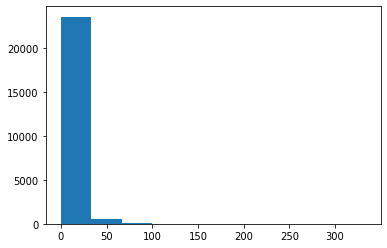

In [108]:
len_list = []
for x in X_data:
  ln = len(x)
  len_list.append(ln)
  if mx < ln:
    mx = ln
plt.hist(len_list)

In [106]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(50, X_data)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.4130291005291


In [19]:
max_len = 50
padded_X = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [21]:
X_pos = padded_X[y_data==1]

In [112]:
split_X_gen, y_gen = text_generator(padded_X, y_data, synonyms)
mix_X = X_data + split_X_gen
mix_y = np.hstack((y_data, y_gen))

In [114]:
max_len = 50
X_pad = pad_sequences(
    sequences=vectorize_data(mix_X, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [115]:
X_train, X_vt, y_train, y_vt = train_test_split(X_pad, mix_y, test_size=0.1, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.3, shuffle=True, random_state=42)
print('Data preprocessing complete.')

Data preprocessing complete.


In [121]:
model = build_model(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=20)

print('Model train complete.')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_pred_proba = predict_proba(y_train_pred)
test_pred_proba = predict_proba(y_test_pred)

train_preds = class_predict(train_pred_proba)
test_preds = class_predict(test_pred_proba)

print('Data predict complete.')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 50)       4885200     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 50, 128)      58880       embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) [(None, 50, 128), (N 98816       bidirectional_6[0][0]            
____________________________________________________________________________________________

In [132]:
def predictor(text, vocab=ft_model.wv.vocab, maxlen=max_len, stopwords=stopwords):
  pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
  text = re.sub(pattern, ' ', text)
  mecab = Mecab()
  tokenized = mecab.morphs(text)
  tokenized = [token for token in tokenized if not token in stopwords]
  tokenized_split = [spliter(n) for n in tokenized]
  tokenized_padded = pad_sequences(sequences=vectorize_data(tokenized_split, vocab=vocab), maxlen=maxlen, padding='post')

  text = [spliter(text)]
  padded = pad_sequences(sequences=vectorize_data(text, vocab=vocab), maxlen=maxlen, padding='post')

  ratio = round(model.predict(padded)[0][0] * 100, 2)

  print(f'{ratio}% 확률로 욕설 문장입니다.')
  print('----------------------------------------')
  print('욕설 부분 분석\n')
  for idx, token in enumerate(tokenized):
    print(token + '\t: ' + str(round(model.predict(tokenized_padded)[idx][0] * 100, 2)) +'% 확률로 욕설 부분') 

In [139]:
text = '아이유 이번 신곡은 스트로베리 문입니다.'
predictor(text)



99.99% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

아이유	: 83.02% 확률로 욕설 부분
이번	: 97.83% 확률로 욕설 부분
신곡	: 95.75% 확률로 욕설 부분
스트로베리	: 99.22% 확률로 욕설 부분
문	: 55.1% 확률로 욕설 부분
입니다	: 92.39% 확률로 욕설 부분


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/LM/ft_310k_spliter_simple_BiLSTM_double_Synonym')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LM/ft_310k_spliter_simple_BiLSTM_double_Synonym/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LM/ft_310k_spliter_simple_BiLSTM_double_Synonym/assets


In [126]:
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

valid_pred_proba = predict_proba(y_valid_pred)
test_pred_proba = predict_proba(y_test_pred)

valid_preds = class_predict(valid_pred_proba)
test_preds = class_predict(test_pred_proba)

In [128]:
sum(y_test)
len(y_test)

1176

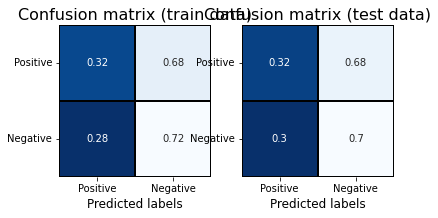

In [129]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_valid, valid_preds, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, test_preds, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])